# Regressione livello precipitazioni

In [1]:
!pip install pyspark

In [2]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
# initialize a new Spark Context to use for the execution of the script
sc = SparkContext(appName="MY-APP-NAME", master="local[*]")
sqlCtx = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [3]:
from google.colab import drive
drive.mount('/content/drive/')
filename = 'drive/MyDrive/DDAM/Australia Rain/rain_tomorrow_australia.csv'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
spark = SparkSession.builder \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [5]:
# carico il dataframe
df = spark.read.load(filename, format="csv", sep=",", inferSchema="true", header="true")

In [6]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- Evaporation: double (nullable = true)
 |-- Sunshine: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- Cloud9am: double (nullable = true)
 |-- Cloud3pm: double (nullable = true)
 |-- Temp9am: double (nullable = true)
 |-- Temp3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RISK_MM: double (nullable = true)
 |-- RainTom

In [7]:
df.show()

+---+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+-------+------------+
|_c0|      Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RISK_MM|RainTomorrow|
+---+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+-------+------------+
|  0|01/12/2008|  Albury|   13.4|   22.9|     0.6|        3.2|     5.6|          W|         44.0|         W|       WNW|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|     8.0|     2.0|   16.9|   2

In [8]:
from pyspark.sql.functions import col

df = df.filter(df["Rainfall"].isNotNull())
df = df.filter(df["MinTemp"].isNotNull())
df = df.filter(df["MaxTemp"].isNotNull())
df = df.filter(df["WindGustSpeed"].isNotNull())
df = df.filter(df["Humidity9am"].isNotNull())
df = df.filter(df["Humidity3pm"].isNotNull())

In [9]:
df = df.drop('_c0',"Date",'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm',"WindSpeed9am","WindSpeed3pm","Temp9am","Temp3pm","Sunshine","RainToday","RainTomorrow")
df.show()

+-------+-------+--------+-----------+-------------+-----------+-----------+-----------+-----------+--------+--------+-------+
|MinTemp|MaxTemp|Rainfall|Evaporation|WindGustSpeed|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|RISK_MM|
+-------+-------+--------+-----------+-------------+-----------+-----------+-----------+-----------+--------+--------+-------+
|   13.4|   22.9|     0.6|        3.2|         44.0|       71.0|       22.0|     1007.7|     1007.1|     8.0|     2.0|    0.0|
|    7.4|   25.1|     0.0|        3.2|         44.0|       44.0|       25.0|     1010.6|     1007.8|     4.0|     2.0|    0.0|
|   12.9|   25.7|     0.0|        3.2|         46.0|       38.0|       30.0|     1007.6|     1008.7|     4.0|     2.0|    0.0|
|    9.2|   28.0|     0.0|        3.2|         24.0|       45.0|       16.0|     1017.6|     1012.8|     4.0|     2.0|    1.0|
|   17.5|   32.3|     1.0|        3.2|         41.0|       82.0|       33.0|     1010.8|     1006.0|     7.0|  

In [10]:
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt

def value_counts(spark_df, colm, order=1, n=10):

    if order==1 :
        return pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.desc_nulls_first("count")).head(n),columns=["value","count"]) 
    if order==2 :
        return pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.asc(colm)).head(n),columns=["value","count"]) 
    if order==3 :
        return pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.desc(colm)).head(n),columns=["value","count"]) 
    if order==4 :
        return pd.concat([pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.asc(colm)).head(n),columns=["value","count"]),
                          pd.DataFrame(spark_df.select(colm).groupBy(colm).count().orderBy(F.desc(colm)).head(n),columns=["value","count"])])

Text(0.5, 0, 'RISK_MM')

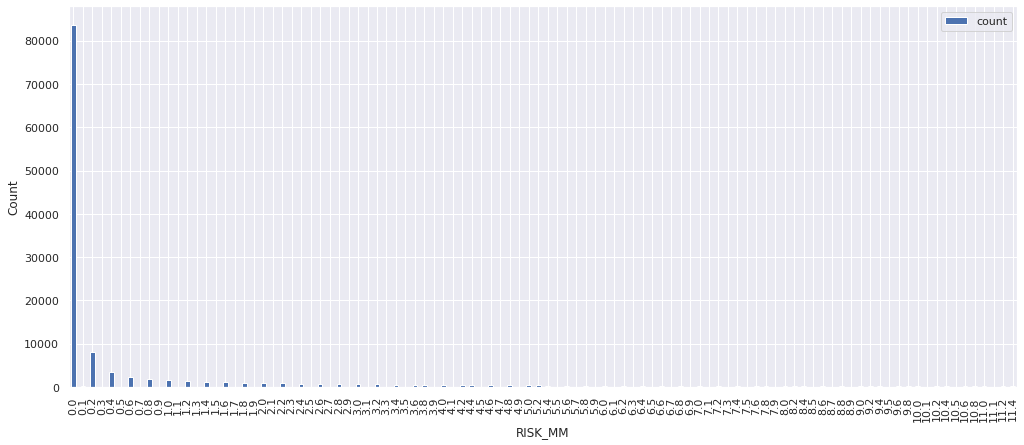

In [11]:
import seaborn as sns
count = value_counts(df, 'RISK_MM', order=2, n=100)
sns.set(rc={'figure.figsize':(17,7)})
count.plot.bar('value','count')
plt.ylabel('Count')
plt.xlabel('RISK_MM')

In [12]:
from pyspark.ml.feature import VectorAssembler

feature_list = []
for col in df.columns:
  if col != "RISK_MM":
    feature_list.append(col)
    
assembler = VectorAssembler(
    inputCols=feature_list,
    outputCol="features")

df = assembler.transform(df)
df.select('features').show()

+--------------------+
|            features|
+--------------------+
|[13.4,22.9,0.6,3....|
|[7.4,25.1,0.0,3.2...|
|[12.9,25.7,0.0,3....|
|[9.2,28.0,0.0,3.2...|
|[17.5,32.3,1.0,3....|
|[14.6,29.7,0.2,3....|
|[14.3,25.0,0.0,3....|
|[7.7,26.7,0.0,3.2...|
|[9.7,31.9,0.0,3.2...|
|[13.1,30.1,1.4,1....|
|[13.4,30.4,0.0,3....|
|[15.9,21.7,2.2,3....|
|[15.9,18.6,15.6,3...|
|[12.6,21.0,3.6,1....|
|[14.1,20.9,0.0,3....|
|[13.5,22.9,16.8,3...|
|[11.2,22.5,10.6,1...|
|[9.8,25.6,0.0,3.2...|
|[11.5,29.3,0.0,3....|
|[17.1,33.0,0.0,3....|
+--------------------+
only showing top 20 rows



In [13]:
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(df)

# Normalize each feature to have unit standard deviation.
df = scalerModel.transform(df)
df.select('scaledFeatures').show(5)

+--------------------+
|      scaledFeatures|
+--------------------+
|[2.08204710014269...|
|[1.14978720455641...|
|[2.00435877551050...|
|[1.42946517323229...|
|[2.71909136212665...|
+--------------------+
only showing top 5 rows



## Linear Regression

In [14]:
from pyspark.ml.regression import LinearRegression

train, test = df.randomSplit([0.7, 0.3])

lr = LinearRegression(featuresCol="scaledFeatures",labelCol='RISK_MM', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

Coefficients: [0.15515161884986506,0.2203867792818102,1.5353771984311506,0.0,0.6151847246872295,0.0,1.9719796003308663,0.0,-0.5716878222286161,0.0,0.3301172759146961]
Intercept: 78.56794836684482


In [15]:
# Make predictions.
predictions = lrModel.transform(test)

# Select example rows to display.
predictions.select("prediction", "RISK_MM", "scaledFeatures").show(5)

+------------------+-------+--------------------+
|        prediction|RISK_MM|      scaledFeatures|
+------------------+-------+--------------------+
| 7.625180873589031|    1.0|[-1.1653248694828...|
|2.3998166729518573|    0.0|[-1.1653248694828...|
| 6.630445951295243|    0.2|[-1.1342495396299...|
| 6.497276727643396|   20.4|[-1.1031742097771...|
| 4.128315257871776|    0.0|[-1.0876365448506...|
+------------------+-------+--------------------+
only showing top 5 rows



In [16]:
predictions.createOrReplaceTempView("tmp")

In [17]:
query = sqlCtx.sql("SELECT prediction, RISK_MM FROM tmp WHERE RISK_MM = 0.8  ORDER BY RISK_MM DESC")
query.show()

+--------------------+-------+
|          prediction|RISK_MM|
+--------------------+-------+
|  0.6884965827494085|    0.8|
| 0.31476633424817635|    0.8|
|   3.300142128145879|    0.8|
|  0.7260996733729996|    0.8|
|   4.739459327519384|    0.8|
|   5.048577614371638|    0.8|
|  3.1362875210305248|    0.8|
|    5.06274539545872|    0.8|
|  2.0944045763544636|    0.8|
|   5.995001528079342|    0.8|
|    9.63510798732861|    0.8|
|  2.6453308212679474|    0.8|
|  0.7935421357204291|    0.8|
|-0.21938380970340177|    0.8|
|   5.001785123729505|    0.8|
|   3.203369943285068|    0.8|
|   1.110929208859332|    0.8|
|  3.3338464095136118|    0.8|
|   1.934171550444276|    0.8|
|  0.6569466855877266|    0.8|
+--------------------+-------+
only showing top 20 rows



In [18]:
# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 10
objectiveHistory: [0.4999999999999999, 0.4791387624851738, 0.43335229296536204, 0.43068014428986207, 0.42796234761242524, 0.4275639159330037, 0.4274280978500768, 0.4273744586767055, 0.427324643767091, 0.42728480645197936, 0.4272693202199885]


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-------------------+
|          residuals|
+-------------------+
|-2.5131494965938543|
| -4.249817063104413|
| 2.0273730655187023|
| -5.081422708423486|
| 3.2902188243345023|
|-2.5687786892002094|
| 13.147596912501239|
| 2.1705202936640804|
| 0.8119806788585606|
| 1.2479951562891785|
| 1.0792160667494528|
| 1.5749464639791313|
|-0.7735489787833103|
| -4.179262726395876|
| 0.1603362602044996|
| 1.8048597959846973|
| -7.049731052312779|
| 1.9410069361796758|
| -5.891407487614188|
|-3.8478018362359734|
+-------------------+
only showing top 20 rows

RMSE: 7.371636
r2: 0.184925


In [19]:
lrModel.coefficients

DenseVector([0.1552, 0.2204, 1.5354, 0.0, 0.6152, 0.0, 1.972, 0.0, -0.5717, 0.0, 0.3301])

In [20]:
#TEST
from  pyspark.ml.evaluation import RegressionEvaluator

# Make predictions.
predictions = lrModel.transform(test)

evaluator = RegressionEvaluator(
    labelCol="RISK_MM", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="RISK_MM", predictionCol="prediction", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)

Root Mean Squared Error (RMSE) on test data = 7.68755
R sqaure = 0.197403


In [21]:
from pyspark.ml.regression import LinearRegression
train = train.drop('prediction')

lr = LinearRegression(featuresCol="scaledFeatures",labelCol='RISK_MM', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

Coefficients: [0.15515161884986506,0.2203867792818102,1.5353771984311506,0.0,0.6151847246872295,0.0,1.9719796003308663,0.0,-0.5716878222286161,0.0,0.3301172759146961]
Intercept: 78.56794836684482


In [22]:
# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 10
objectiveHistory: [0.4999999999999999, 0.4791387624851738, 0.43335229296536204, 0.43068014428986207, 0.42796234761242524, 0.4275639159330037, 0.4274280978500768, 0.4273744586767055, 0.427324643767091, 0.42728480645197936, 0.4272693202199885]


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-------------------+
|          residuals|
+-------------------+
|-2.5131494965938543|
| -4.249817063104413|
| 2.0273730655187023|
| -5.081422708423486|
| 3.2902188243345023|
|-2.5687786892002094|
| 13.147596912501239|
| 2.1705202936640804|
| 0.8119806788585606|
| 1.2479951562891785|
| 1.0792160667494528|
| 1.5749464639791313|
|-0.7735489787833103|
| -4.179262726395876|
| 0.1603362602044996|
| 1.8048597959846973|
| -7.049731052312779|
| 1.9410069361796758|
| -5.891407487614188|
|-3.8478018362359734|
+-------------------+
only showing top 20 rows

RMSE: 7.371636
r2: 0.184925


In [23]:
lrModel.coefficients

DenseVector([0.1552, 0.2204, 1.5354, 0.0, 0.6152, 0.0, 1.972, 0.0, -0.5717, 0.0, 0.3301])

In [24]:
# Make predictions.
predictions = lrModel.transform(test)

evaluator = RegressionEvaluator(
    labelCol="RISK_MM", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="RISK_MM", predictionCol="prediction", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)

Root Mean Squared Error (RMSE) on test data = 7.68755
R sqaure = 0.197403


In [25]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
train, test = df.randomSplit([0.7, 0.3])
lr = LinearRegression(featuresCol="scaledFeatures",labelCol='RISK_MM', maxIter=10, regParam=0.3, elasticNetParam=0.8)
# grid search
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [x for x in range(1, 10, 5)])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

# cross-validation
crossval = CrossValidator(estimator=lr,
                          numFolds= 10,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(labelCol='RISK_MM',
                                                                   rawPredictionCol='prediction',
                                                                   metricName="areaUnderROC"))

cvModel = crossval.fit(train)
bestModel = cvModel.bestModel

In [26]:
predictions = bestModel.transform(test)
predictions.select('RISK_MM', 'prediction', 'scaledFeatures').show(5)

+-------+-------------------+--------------------+
|RISK_MM|         prediction|      scaledFeatures|
+-------+-------------------+--------------------+
|    0.8|  4.845062608081683|[-1.2740885239679...|
|    0.8| 5.4574213916039795|[-1.2119378642621...|
|    0.0|-3.8005319965475834|[-1.1808625344092...|
|    0.2|  7.241515178481528|[-1.1342495396299...|
|    0.2|-2.4999854479614143|[-1.0876365448506...|
+-------+-------------------+--------------------+
only showing top 5 rows



In [27]:
predictions.createOrReplaceTempView("tmp")

In [28]:
query = sqlCtx.sql("SELECT prediction, RISK_MM FROM tmp WHERE RISK_MM = 0.8 ORDER BY RISK_MM ASC")
query.show()

+--------------------+-------+
|          prediction|RISK_MM|
+--------------------+-------+
| 0.36301542506907936|    0.8|
|-0.05773757524408296|    0.8|
|  1.3662799591438954|    0.8|
| 0.35788250996192517|    0.8|
|   3.869793431623542|    0.8|
|    9.38025642743196|    0.8|
| 0.36755800708908026|    0.8|
|  1.1803599754774368|    0.8|
|  2.1522923427003633|    0.8|
|  3.8696972682390296|    0.8|
|  0.6860327050728969|    0.8|
|  0.8643138519417803|    0.8|
|  0.5313098166034109|    0.8|
|    5.27295788575784|    0.8|
|   3.398882036419039|    0.8|
| -3.1459779577574807|    0.8|
|   5.020442625528943|    0.8|
|  1.1064106125729651|    0.8|
|0.045619537556227385|    0.8|
|  3.8775494934729906|    0.8|
+--------------------+-------+
only showing top 20 rows



In [29]:
evaluator = RegressionEvaluator(
    labelCol="RISK_MM", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="RISK_MM", predictionCol="prediction", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)

Root Mean Squared Error (RMSE) on test data = 7.43862
R sqaure = 0.194937


## Random Forest regressor

In [30]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

train, test = df.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="scaledFeatures",labelCol='RISK_MM')

# Train model.  This also runs the indexer.
model = rf.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("RISK_MM", "prediction", "scaledFeatures").show(5)

+-------+-----------------+--------------------+
|RISK_MM|       prediction|      scaledFeatures|
+-------+-----------------+--------------------+
|    0.8|6.304724471228573|[-1.2740885239679...|
|    0.8|6.258649066429805|[-1.2119378642621...|
|    0.0| 1.61838009348252|[-1.1653248694828...|
|   19.2|6.799905858255457|[-1.0876365448506...|
|    0.0| 6.55589070004005|[-1.0876365448506...|
+-------+-----------------+--------------------+
only showing top 5 rows



In [31]:
evaluator = RegressionEvaluator(
    labelCol="RISK_MM", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="RISK_MM", predictionCol="prediction", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)

Root Mean Squared Error (RMSE) on test data = 7.11758
R sqaure = 0.299625


In [32]:
model.featureImportances

SparseVector(11, {0: 0.1202, 1: 0.0297, 2: 0.1588, 3: 0.032, 4: 0.0435, 5: 0.055, 6: 0.4263, 7: 0.0152, 8: 0.0343, 9: 0.0048, 10: 0.0802})

In [33]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

train = train.drop('prediction')

# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="scaledFeatures",labelCol='RISK_MM')

# Train model.  This also runs the indexer.
model = rf.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("RISK_MM", "prediction", "scaledFeatures").show(5)

+-------+-----------------+--------------------+
|RISK_MM|       prediction|      scaledFeatures|
+-------+-----------------+--------------------+
|    0.8|6.304724471228573|[-1.2740885239679...|
|    0.8|6.258649066429805|[-1.2119378642621...|
|    0.0| 1.61838009348252|[-1.1653248694828...|
|   19.2|6.799905858255457|[-1.0876365448506...|
|    0.0| 6.55589070004005|[-1.0876365448506...|
+-------+-----------------+--------------------+
only showing top 5 rows



In [34]:
evaluator = RegressionEvaluator(
    labelCol="RISK_MM", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="RISK_MM", predictionCol="prediction", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)

Root Mean Squared Error (RMSE) on test data = 7.11758
R sqaure = 0.299625


In [35]:
model.trees

[DecisionTreeRegressionModel: uid=dtr_7474b22ef485, depth=5, numNodes=63, numFeatures=11,
 DecisionTreeRegressionModel: uid=dtr_3fa91d14407e, depth=5, numNodes=63, numFeatures=11,
 DecisionTreeRegressionModel: uid=dtr_8c86a1afb870, depth=5, numNodes=63, numFeatures=11,
 DecisionTreeRegressionModel: uid=dtr_16b026331dc5, depth=5, numNodes=63, numFeatures=11,
 DecisionTreeRegressionModel: uid=dtr_ff7422a302f2, depth=5, numNodes=63, numFeatures=11,
 DecisionTreeRegressionModel: uid=dtr_f1565dca9a82, depth=5, numNodes=61, numFeatures=11,
 DecisionTreeRegressionModel: uid=dtr_b9831a0c748c, depth=5, numNodes=63, numFeatures=11,
 DecisionTreeRegressionModel: uid=dtr_f3c621d5733c, depth=5, numNodes=63, numFeatures=11,
 DecisionTreeRegressionModel: uid=dtr_a3119da8f414, depth=5, numNodes=63, numFeatures=11,
 DecisionTreeRegressionModel: uid=dtr_a4d54468d2ad, depth=5, numNodes=63, numFeatures=11,
 DecisionTreeRegressionModel: uid=dtr_37c27a8b53db, depth=5, numNodes=63, numFeatures=11,
 DecisionT

In [36]:
model.featureImportances

SparseVector(11, {0: 0.1202, 1: 0.0297, 2: 0.1588, 3: 0.032, 4: 0.0435, 5: 0.055, 6: 0.4263, 7: 0.0152, 8: 0.0343, 9: 0.0048, 10: 0.0802})

In [37]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
train, test = df.randomSplit([0.7, 0.3])
# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="scaledFeatures",labelCol='RISK_MM')
# grid search
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [  x for x in range( 1, 10, 5 )   ]) \
    .addGrid(rf.numTrees, [  x for x in range( 1, 10, 5 )   ]) \
    .build()

# cross-validation
crossval = CrossValidator(estimator=rf,
                          numFolds= 10,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(labelCol='RISK_MM',
                                                                   rawPredictionCol='prediction',
                                                                   metricName="areaUnderROC"))

cvModel = crossval.fit(train)
bestModel = cvModel.bestModel

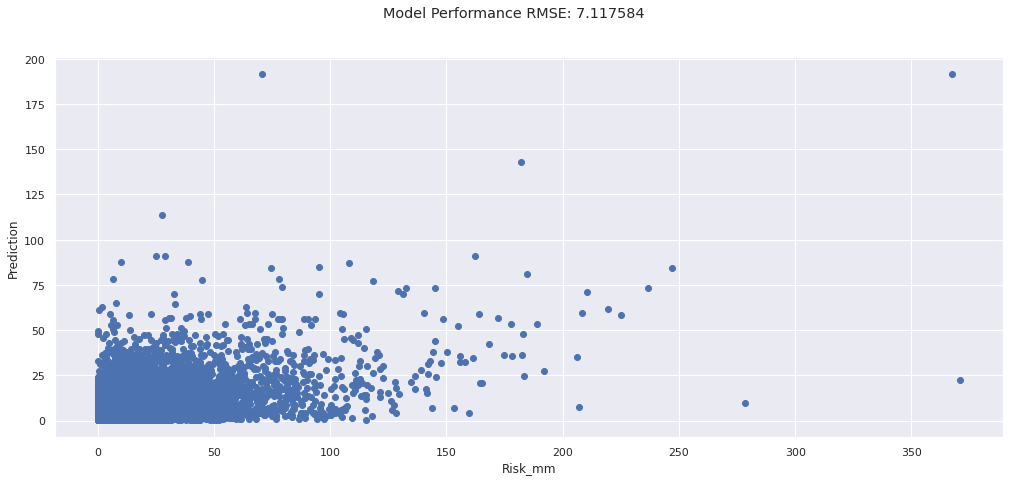

In [38]:
rfPred = cvModel.transform(df)
rfResult = rfPred.toPandas()
plt.plot(rfResult.RISK_MM, rfResult.prediction, 'bo')
plt.xlabel('Risk_mm')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

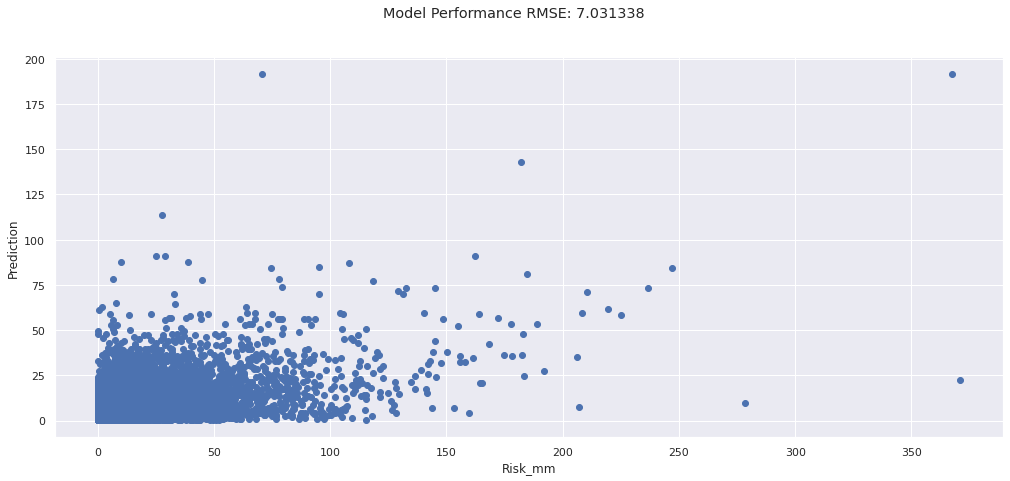

In [44]:
import matplotlib.pyplot as plt
evaluator = RegressionEvaluator(labelCol="RISK_MM", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rfPred = cvModel.transform(df)
rfResult = rfPred.toPandas()
plt.plot(rfResult.RISK_MM, rfResult.prediction, 'bo')
plt.xlabel('Risk_mm')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

In [45]:
feature_list = []
for col in df.columns:
  if col != "RISK_MM":
    feature_list.append(col)

Text(0.5, 1.0, 'Feature Importances')

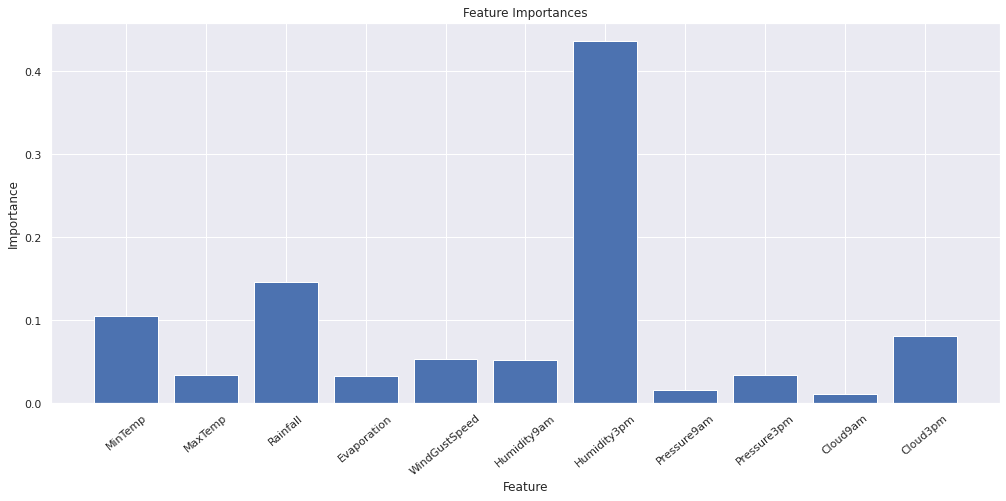

In [46]:
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df)
pipeline = Pipeline(stages=[featureIndexer, rf])

# Train model.  This also runs the indexer.
model = pipeline.fit(train)
predictions = bestModel.transform(test)
bestPipeline = cvModel.bestModel
bestModel = model.stages[1]
importances = bestModel.featureImportances
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [41]:
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

numTrees -  6
maxDepth -  6


In [42]:
predictions = bestModel.transform(test)
predictions.select('RISK_MM', 'prediction','scaledFeatures').show(5)

+-------+-------------------+--------------------+
|RISK_MM|         prediction|      scaledFeatures|
+-------+-------------------+--------------------+
|    0.0|0.44089996526537895|[-1.2740885239679...|
|    0.0|  0.479598552218606|[-1.1808625344092...|
|    0.2|  6.031503047538995|[-1.1342495396299...|
|    3.6|  6.031503047538995|[-1.1187118747035...|
|    0.2|  0.479598552218606|[-1.0876365448506...|
+-------+-------------------+--------------------+
only showing top 5 rows



In [43]:
evaluator = RegressionEvaluator(
    labelCol="RISK_MM", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

evaluator = RegressionEvaluator(
    labelCol="RISK_MM", predictionCol="prediction", metricName="r2")
rsq = evaluator.evaluate(predictions)
print("R sqaure = %g" % rsq)

Root Mean Squared Error (RMSE) on test data = 7.03134
R sqaure = 0.296035
